# Lesson 4: Intro to Data Science, PyMC and ArviZ

Now that we covered the intuition behind Bayesian modeling and sampling, let's roll up our sleeves and get to actual modeling.

In this lesson, you will learn about:

1. Generating data
    - How to generate data
    - Why it’s interesting to understand a model
    - Doing it in Python

2. PyMC'ntroduction
    - Coding a model
    - Fitting a model
3. Intro to ArviZ
    - What is ArviZ
    - When and why use it

4. More PyMC joy
    - How to do it properly
    - Fitting the AB test model
5. The distribution of Bayesian tools
    - There isn't just one probabilistic programming languages
    - We’ll be using PyMC here

6. Complementary tools to do Bayesian inference
    - Bayesian analysis includes many other tools
    - We won't cover them in depth here, but we'll mention:
        - Array manipulation with Pandas and Xarray
        - Visualization with Matplotlib, Altair, Bokeh, Plotly, etc.

Let's dive right into it and see how we define a model in PyMC and then perform inference! Are you as excited as I am??

A word of caution: some parts will feel weird and unfamiliar. Don't worry exactly about what all this means just yet. Simply focus on identifying the big parts of the model. You'll have plenty of time to understand the rest throughout this course.

Before anything though, what do we need? Data! Let's just generate some for our first model, that'll make everything easier.

## Generating data

In this section, we'll see how to generate data and use them to fit your models. Why, you say? It does feel like we're cheating, but we're not: generating fake data is actually a very useful step in the Bayesian workflow, as you can then test whether your model recovered the true parameters that generated the data. 

Here you _know_ what your model should say, which is a luxury we don't have in reality, where we rarely know whether our scientific hypothesis is false, or whether our model is poorly coded. But if we've tested it on fake data beforehand, we know that if our hypothesis is true, our model will recover something close to the true parameters.

Now how do we do that exactly? In the python ecosystem, you can mainly use numpy or scipy. In a previous lesson, you saw how to do that with scipy. Here we'll look at numpy.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from scipy import stats

You are running the v4 development version of PyMC which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc/tree/v3


In [2]:
az.style.use("arviz-darkgrid")
RANDOM_SEED = 8265
np.random.seed(RANDOM_SEED)

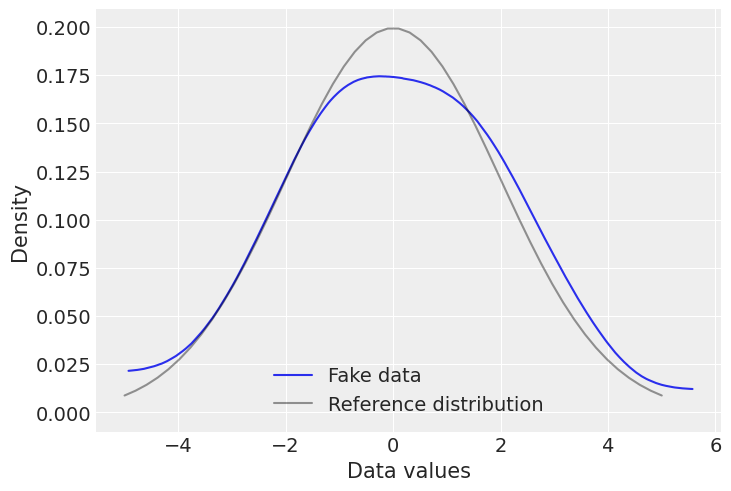

In [3]:
data = np.random.normal(loc=0, scale=2, size=100)

reference = stats.norm(0, 2)
x = np.linspace(-5, 5)
y = reference.pdf(x)

ax = az.plot_dist(data, label="Fake data")
ax.plot(x, y, label="Reference distribution", c="k", alpha=0.4)
ax.set(xlabel="Data values", ylabel="Density")
ax.legend();

Simple, right? Just call numpy's random generator. It has almost all the distributions you'll need built-in.

Remember what this graph represents? It's the PDF of the values we just draw. As expected, most of the values are concentrated around 0, and the PDF looks a bit like a Normal distribution (the classic bell curve, that we draw in grey here, as a reference). If we had drawn more samples with numpy, our blue curve would look even more Normal. Just for fun, we used a standard deviation of 2, instead of the classic value of 1.

### Section recap

- Generating fake data is easy with Numpy.
- The goal is that your model recovers the true latent parameters.
- If it does but doesn't converge on real data, then:
    - You may need to use a different parametrization of the same model.
    - Your data generating story may not be appropriate enough.

Now that we have some data, let's try and model them with PyMC!

## PyMC'ntroduction

### Coding up a PyMC model

By design, we've got a very simple model here:

$$y \sim Normal(\mu, \sigma)$$

In other words, we think our observations ($y$ in the equation above, `obs` in the code below) are normally distributed, with a mean $\mu$ and standard deviation $\sigma$ that we have to infer.

Now, remember what we do in the Bayesian framework when we're uncertain about something? We put a prior over it, exactly! Here, let's use very simple priors (don't worry, we'll explain what they mean in a minute):

$$\mu \sim Normal(0, 1)$$
$$\sigma \sim HalfNormal(1)$$

Now, let's see how this translates into PyMC:

In [4]:
with pm.Model() as model:
    mean = pm.Normal("mean", 0, 1)
    sigma = pm.HalfNormal("sigma", 1)

    obs = pm.Normal(
        "obs",
        mu=mean,
        sigma=sigma,
        observed=data,
    )

Pretty literal traduction, right? In general, PyMC's syntax is very close to the mathematical specification of models -- that's by design, so that models are easier to think about and explain.

There may still be some areas of confusion in your head -- and that's expected, there is a lot going on here. Let's take it line by line. I usually like to go from the bottom to the top to read my models, because that way I start from what I see in the world -- the data!

- `obs` is our likelihood, i.e "which distribution we think the data are sampled from", as we've seen in a previous lesson. Here, we've chosen the Normal distribution (and we know it's a good choice because, well, we've generated the data with a Normal), but we could have chosen something else and see how the model samples and predicts. Always remember: a likelihood is just a prior for the data, and priors are just assumptions, which means you can change them and test them however you want.

- Our Normal likelihood is parametrized by a mean and a standard deviation, for which we need priors. We just used a standard Normal for our mean, and a HalfNormal distribution for our standard deviation. Why a HalfNormal? Because it constrains `sigma` to be positive, which is what we want for a standard deviation parameter. Don't overthink it, we'll get back to this distribution in the lesson about linear regression. Also note that we used a standard deviation of 1 for `sigma`, although we know the true parameter is 2. But it's a good test: we'll see whether the model is able to recover the true value.

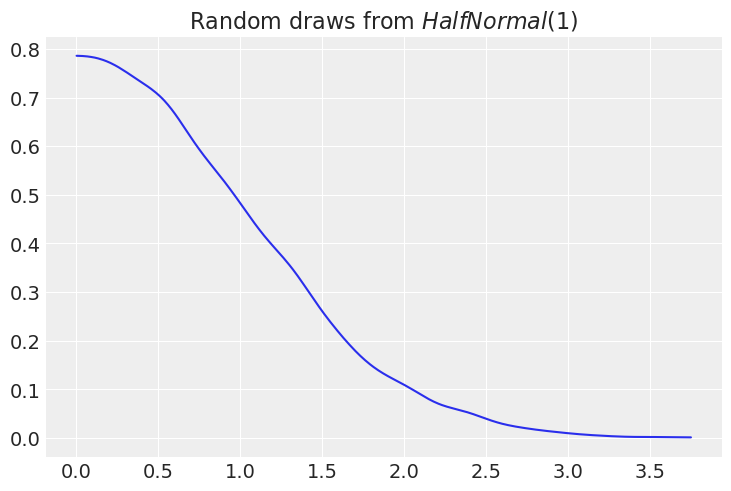

In [5]:
ax = az.plot_dist(stats.halfnorm.rvs(size=10_000))
ax.set_title("Random draws from $HalfNormal(1)$");

I know what you want to do: sample from this model, you little scoundrel! So let's do that!

### Fitting the model

Now it's time to get our hands dirty by sampling from our model! PyMC's `sample` function will fit probability models (which are no more than linked collections of variables) like ours using Markov chain Monte Carlo (MCMC) sampling. Unless we manually assign particular algorithms to variables in our model, PyMC will assign algorithms that it deems appropriate (it usually does a decent job of this).

In [6]:
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean, sigma]
You are running the v4 development version of PyMC which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc/tree/v3
You are running the v4 development version of PyMC which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc/tree/v3
You are running the v4 development version of PyMC which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc/tree/v3
You are running the v4 development version of PyMC which currently still lacks key features. You pr

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


Now, we'll often want to sample from other distributions than just the posterior one. Do you remember which ones are interesting?

That's right: the prior predictive and posterior predictive distributions!

Think of it like this:

- `pm.sample` --> **Posterior** distribution
- `pm.sample_prior_predictive` --> **Prior Predictive** distribution
- `pm.sample_posterior_predictive` --> **Posterior Predictive** distribution

This is just one more line in PyMC:

In [7]:
with model:
    prior = pm.sample_prior_predictive()

And for the posterior predictive:

In [8]:
with model:
    posterior_predictive = pm.sample_posterior_predictive(idata)

### Section recap

- Coding a model in PyMC is very similar to the mathematical specification.
- Fitting a model is straightforward, not only for the posterior distributions but also for the predictive distributions.

Now, how do we visualize things like posteriors and whatnot? With ArviZ of course! Let's take a look!

## ArviZ, for the explorers (of Bayesian models)

In short, ArviZ is your friend for all pre- and post-processing modeling steps, which happen to be very common, no matter the probabilistic language you use (Stan, PyMC, Numpyro, TensorFlow Probability, etc.).

### The `InferenceData` object

- ArviZ converts Bayesian results into a common data structure, called `InferenceData`. 

- It also provides functions to check model convergence, diagnose and criticize models, compare different models, and flexibly plot the results (using either Matplotlib or Bokeh). 

- These tasks are also key to the modelling process and require both numerical and visual tools.

Concretely, `InferenceData` objects contain all relevant information to perform diagnostics on the inference run or to reproduce it -- which means you can share your analysis with your colleagues, aka _the_ dream of any Bayesian. These objects contain several groups, each of which is a multidimensional-labeled array with one or more data variables, as shown in the figure below:

![image](img/InferenceDataStructure.png)

The full schema specification can be found in [ArviZ's documentation](https://arviz-devs.github.io/arviz/schema/schema.html) and is useful to parse through.

These groups contain data related to a specific collection such as _posterior_, _observed data_, or _sampler stats_ (sampler quantities like divergence, tree depth, and log likelihood). 

Don't worry about those technical terms for now, we'll teach you that in the "MCMC for practitioners" lesson. We just mention them here to give you a first exposure.

The two most important concepts you have to bear in mind when using `InferenceData` objects are _dimensions_ and _coordinates_.

The **dimensions** of an object are its named axes. A variable containing 1D data will have dimensions `[chain, draw, dim0]`. Indeed the `chain` and `draw` dimensions are always there (this is the result of a fitted Bayesian model, remember?). And then the variables' dimensions are appended. Every dimension present in an `InferenceData` variable must share names with a coordinate.

A **coordinate** is a named array that labels a dimension. For instance, a coordinate that will always be there will be... you guessed it, `chain`, whose values will be `[0, 1, 2, 3]` if you ran 4 chains. And this coordinate labels the `chain` dimension we saw above. In other words, coordinate names and values can be loosely thought of as labels and their corresponding tick labels along a dimension.

### Manipulating `InferenceData` objects

Remember our first model? This is actually already an `InferenceData` object!

We know, this sounds dry, as any new concept. Just let it think sink in; you will get it, with time and repeated exposure. Actually, a way to jumpstart your understanding of the wonderfulness of `InferenceData` is just to play around with it. Let's first add our prior predictive and posterior predictive samples to the same `InferenceData` object, for easier exploration:

In [9]:
with model:
    idata.extend(prior)
    idata.extend(posterior_predictive)

In [10]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> prior
	> prior_predictive
	> posterior_predictive

In [11]:
# access a group
idata.posterior

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 1000)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
Data variables:
    mean     (chain, draw) float64 0.1959 0.06298 0.0628 ... 0.07809 0.1545
    sigma    (chain, draw) float64 2.153 1.888 1.842 1.88 ... 1.907 1.958 1.913
Attributes:
    created_at:                 2021-10-15T10:25:11.976354
    arviz_version:              0.11.4
    inference_library:          pymc
    inference_library_version:  4.0.0
    sampling_time:              11.722295045852661
    tuning_steps:               1000

In [12]:
# combine chains and draws
idata.posterior.stack(sample=("chain", "draw"))

<xarray.Dataset>
Dimensions:  (sample: 4000)
Coordinates:
  * sample   (sample) MultiIndex
  - chain    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3
  - draw     (sample) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
Data variables:
    mean     (sample) float64 0.1959 0.06298 0.0628 ... 0.1681 0.07809 0.1545
    sigma    (sample) float64 2.153 1.888 1.842 1.88 ... 1.982 1.907 1.958 1.913
Attributes:
    created_at:                 2021-10-15T10:25:11.976354
    arviz_version:              0.11.4
    inference_library:          pymc
    inference_library_version:  4.0.0
    sampling_time:              11.722295045852661
    tuning_steps:               1000

In [13]:
# obtain a numpy array for a given parameter:
idata.posterior["mean"].data

array([[ 0.19591771,  0.06298358,  0.06280303, ...,  0.04994836,
         0.32636153,  0.21687067],
       [ 0.06290372,  0.08683733,  0.33558068, ...,  0.29085573,
         0.29085573, -0.38790289],
       [ 0.02748043, -0.08953083,  0.16132007, ...,  0.39946916,
         0.48613148, -0.09084867],
       [ 0.1575343 ,  0.14195659,  0.13315002, ...,  0.16806789,
         0.07808811,  0.15452943]])

In [14]:
# along all dimensions
idata.posterior.mean()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    mean     float64 0.1144
    sigma    float64 1.943

In [15]:
# specify along which dimension
idata.posterior.mean("draw")

<xarray.Dataset>
Dimensions:  (chain: 4)
Coordinates:
  * chain    (chain) int64 0 1 2 3
Data variables:
    mean     (chain) float64 0.1157 0.1159 0.1122 0.1138
    sigma    (chain) float64 1.939 1.945 1.945 1.943

In [16]:
# any summary function
idata.posterior.quantile(q=[0.25, 0.5, 0.75], dim=("chain", "draw"))

<xarray.Dataset>
Dimensions:   (quantile: 3)
Coordinates:
  * quantile  (quantile) float64 0.25 0.5 0.75
Data variables:
    mean      (quantile) float64 -0.02709 0.1151 0.2537
    sigma     (quantile) float64 1.847 1.933 2.03

`InferenceData` objects are so central to ArviZ that most functions take it as an input. Don't worry, we'll see many examples of ArviZ and `InferenceData` magic throughout the course. 

For more details, you can take a look at the [getting started guide](https://arviz-devs.github.io/arviz/getting_started/index.html) on ArviZ website.

### Checking our inferences

In [17]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean,0.11,0.20,-0.23,0.49,0.0,0.0,3820.53,2854.76,1.0
sigma,1.94,0.14,1.69,2.20,0.0,0.0,3801.65,2662.38,1.0


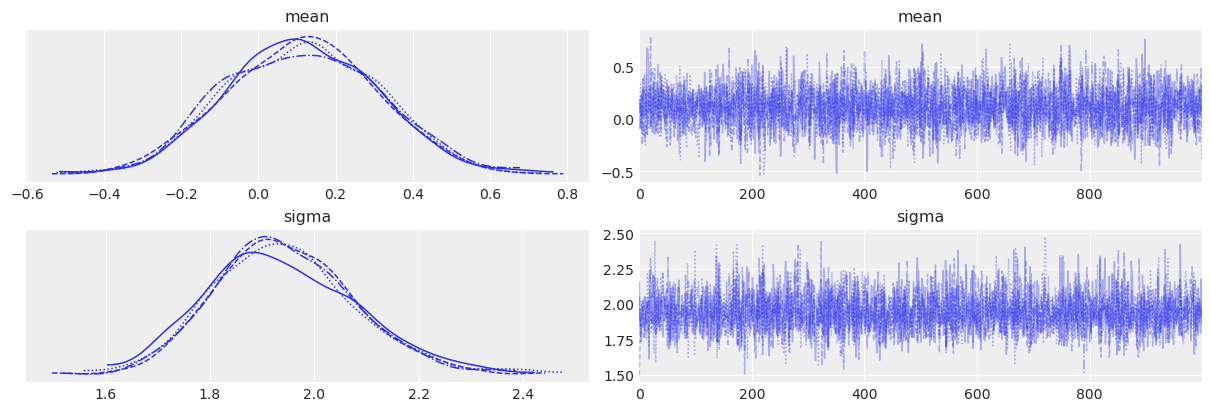

In [18]:
az.plot_trace(idata);

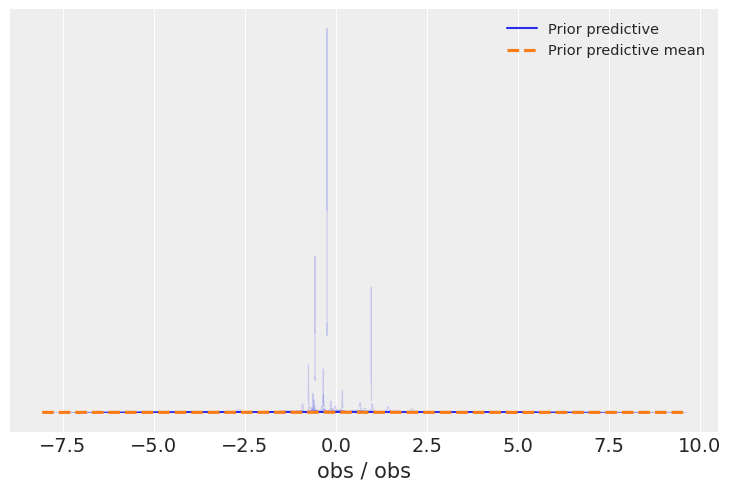

In [19]:
az.plot_ppc(idata, group="prior", observed=False);

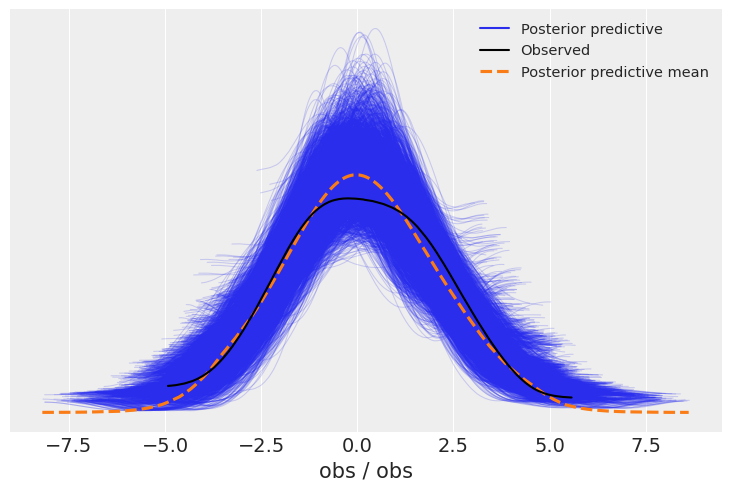

In [20]:
az.plot_ppc(idata);

This is one good looking posterior predictive plot!

### Section recap

- ArviZ is your friend for all pre- and post-processing modeling steps.
- ArviZ converts results into an `InferenceData` objects and provides functions to check, compare and criticize models, and flexibly plot the results.
- `InferenceData` objects are structured around `dimensions` and `coordinates`.
- Teaser: `dimensions` and `coordinates` can be used directly in PyMC models (seen in a later lesson).

## More PyMC joy

### Installing PyMC

As PyMC is an actively developed package, the best practices for installation can sometimes change, so the best resource to be up-to-date is to take a look at the Wikis online. There is one for each platform: [MacOS](https://github.com/pymc-devs/PyMC/wiki/Installation-Guide-(MacOS)), [Windows](https://github.com/pymc-devs/PyMC/wiki/Installation-Guide-(Windows)) and [Linux](https://github.com/pymc-devs/PyMC/wiki/Installation-Guide-(Linux)).

Let's go to the terminal to install PyMC in a brand new virtual environment on MacOS!

### AB test model

Remember the AB test model we worked on since the start of the course? Well now we get to fit it with PyMC! Here it is:

In [21]:
N_trials = 100
true_rate = 0.1
a_observations = stats.bernoulli(p=true_rate).rvs(N_trials)
a_observations

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [22]:
with pm.Model() as model_a:
    # Parameter = prior solution space
    conversion_rate = pm.Beta("conversion_rate_a", alpha=2, beta=10)

    # Evaluator: likelihood function
    how_likely = pm.Bernoulli("how_likely", p=conversion_rate, observed=a_observations)

#### Checking the prior

Before sampling though, why did we choose this prior for the conversion rate? A good way to make sense of it is to sample from the prior and then plot it:

In [23]:
with model_a:
    prior_a = pm.sample_prior_predictive()

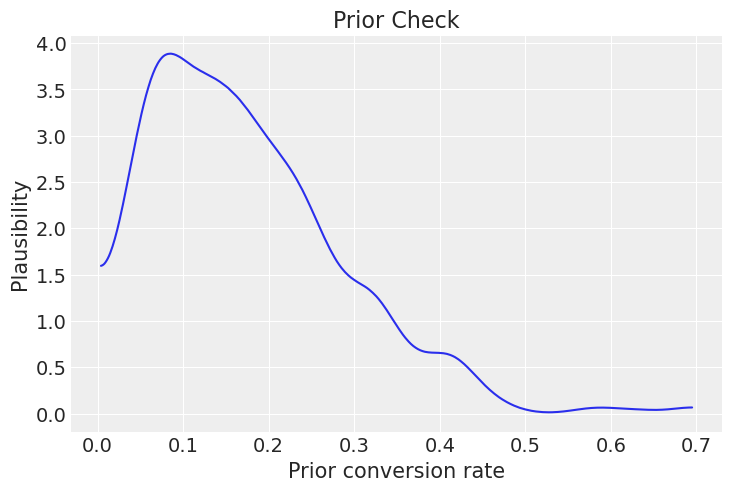

In [24]:
ax = az.plot_dist(prior_a.prior["conversion_rate_a"])
ax.set(xlabel="Prior conversion rate", ylabel="Plausibility", title="Prior Check");

That means that, before seeing any data, we expect our conversion rate to be between 0 and 0.6, with most of the probability mass until 0.3. That makes sense, right? Conversion rates are usually low.

But **how does that translate to the outcome space (aka the data space)?** Does the model generate sensible plausible observations before seeing any data? Let's check, with the same kind of plot as above!

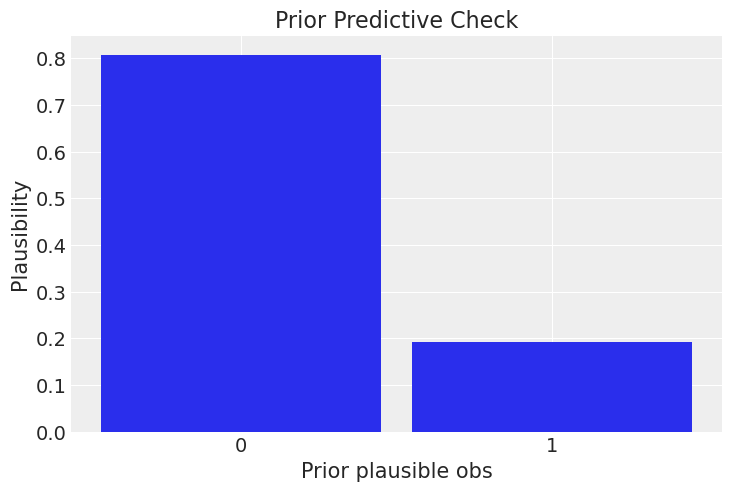

In [25]:
ax = az.plot_dist(prior_a.prior_predictive["how_likely"])
ax.set(
    xlabel="Prior plausible obs", ylabel="Plausibility", title="Prior Predictive Check"
);

Yep, that does make sense and fits our domain knowledge. Now is the time to let our model see the data and update our knowledge if needed!

#### Sampling from the model

In [36]:
with model_a:
    # Posterior solution space
    plausible_values_a = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate_a]
You are running the v4 development version of PyMC which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc/tree/v3
You are running the v4 development version of PyMC which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc/tree/v3
You are running the v4 development version of PyMC which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc/tree/v3
You are running the v4 development version of PyMC which currently still lacks key features. 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


Sampling worked seamlessly! Now, let's explore our inferences, like we did with our previous model:

In [27]:
az.summary(plausible_values_a, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
conversion_rate_a,0.1,0.03,0.05,0.15,0.0,0.0,1717.81,2788.22,1.0


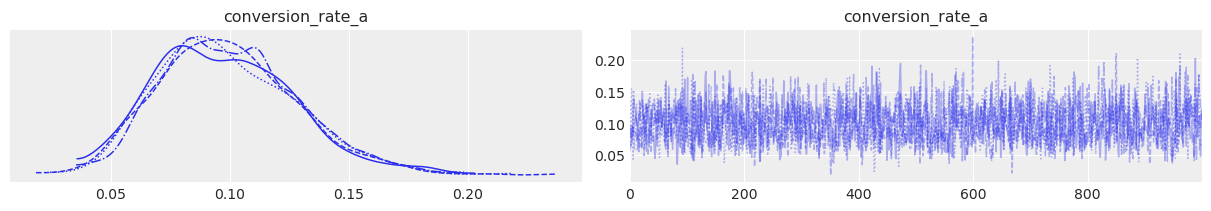

In [28]:
az.plot_trace(plausible_values_a);

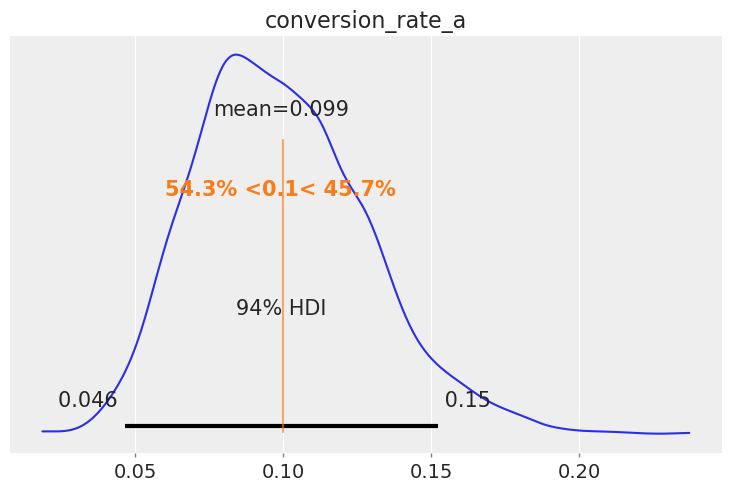

In [29]:
az.plot_posterior(plausible_values_a, ref_val=true_rate);

Looks like our model was able to recover the true latent conversion rate, although with substantial uncertainty -- which is actually expected: we only have 100 samples after all!

It's also interesting to compare our posterior for the conversion rate to our prior, and notice how the latter was updated when data were observed:

In [39]:
with model_a:
    plausible_values_a.extend(prior_a)

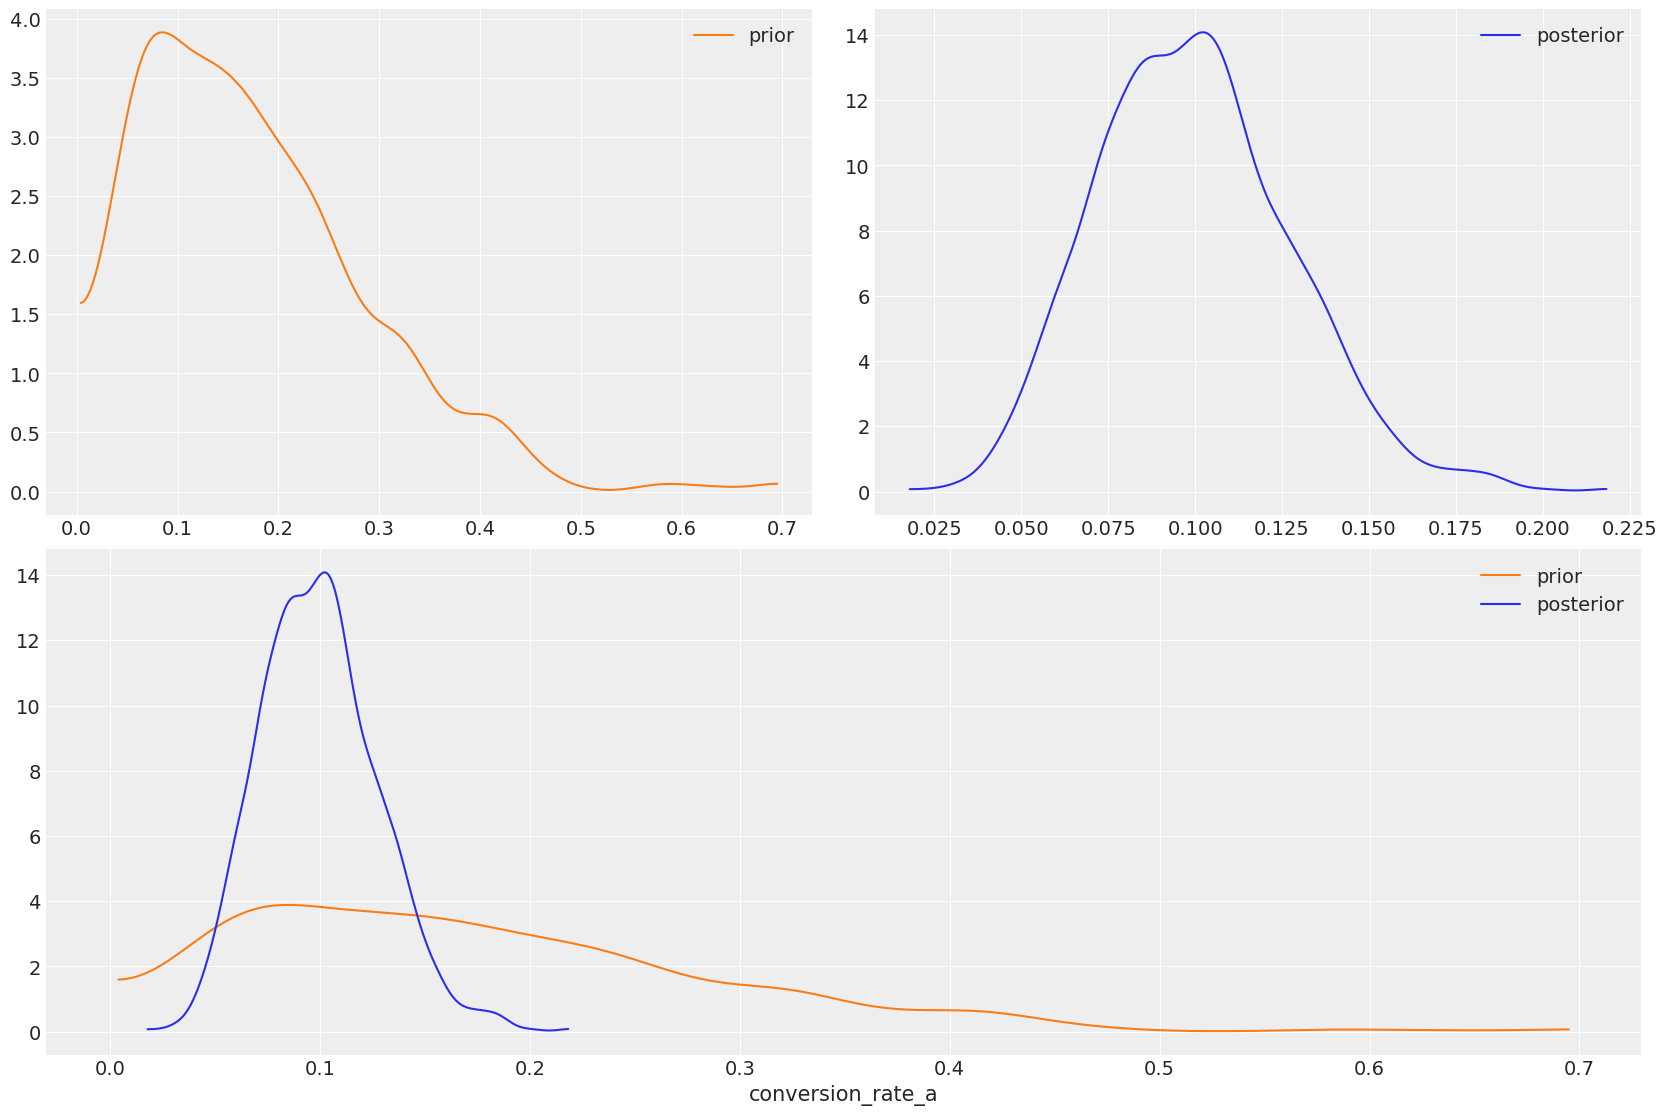

In [40]:
az.plot_dist_comparison(plausible_values_a);

But same question as when we looked at the prior: **how does that translate to the outcome space?**. Does the model generate sensible plausible observations _after_ seeing the data? That's what's called a **posterior predictive check**, and for that we need... posterior predictive samples, you guessed it!

Let's ask PyMC for those, and then draw our plot, overlaying the data for comparison:

In [37]:
with model_a:
    posterior_predictive_a = pm.sample_posterior_predictive(plausible_values_a)
    plausible_values_a.extend(posterior_predictive_a)

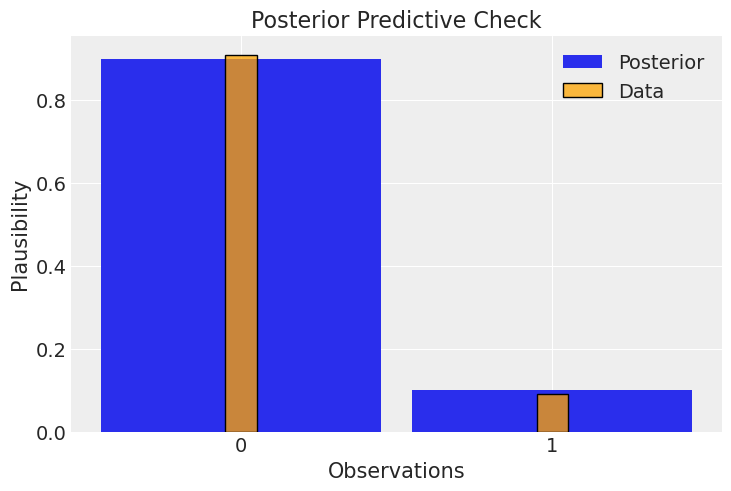

In [32]:
ax = az.plot_dist(
    plausible_values_a.posterior_predictive["how_likely"],
    label="Posterior",
)
sns.histplot(
    plausible_values_a.observed_data["how_likely"],
    stat="probability",
    ax=ax,
    color="orange",
    discrete=True,
    shrink=0.1,
    label="Data",
)
ax.legend()
ax.set(
    xlabel="Observations",
    ylabel="Plausibility",
    title="Posterior Predictive Check",
);

I'd say that looks very good, doesn't it?

### Section recap

- Prefer conda to install PyMC -- the C compiler infrastructure will be taken care of for you.
- You know how to do a Bayesian AB test in PyMC now!

## Section 5: The distribution of Bayesian tools

You saw how important distributions are in the Bayesian framework. Well, you'll be happy to learn that there is a whole distribution of probabilistic programming languages (PPL). We won't go into the details of "what is a PPL" in this course, but if you're curious about that, I'd recommend listening to [episode 3 of the "Learning Bayesian Statistics" podcast](https://www.learnbayesstats.com/episode/3-1-what-is-probabilistic-programming-why-use-it-with-colin-carroll).

Now, concretely, you may have heard of Stan or NumPyro. And obviously you're here because you know of PyMC, which is the PPL we'll be using in this course, because of its simplicity of syntax and advanced sampling capabilities. Don't worry about getting "locked in" -- once you get the intuition, you can use any Bayesian tool!

![image](img/ppls.png)

Just a few words about PyMC development, because we want this to be very clear for you.
In this course, we'll use PyMC 4.0 (and its new backend, Aesara), because it's the future, and we want you to have the best tools at your disposal!

You may be mostly familiar with the previous major version, PyMC3. But rest assured: the whole core-dev team worked hard to make sure the API you love stayed mainly the same -- the best of both world: still easy-to-use, but better performance! What else?

Actually, here is a timeline that will make all that clear:

![image](img/pymc-timeline.png)

### Section recap

- PyMC is not the only PPL.
- We've designed it to be easy to use for practitioners.
- We'll be using PyMC 4.0, to bring you the best!

## Complementary tools to do Bayesian inference

Bayesian analysis is not done in a vacuum. The workflow typically includes other open-source libraries you've already seen in this course, like numpy and scipy, but let's explore a bit more, especially around array manipulation and visualization.

### Array manipulation

Almost all the time, you'll also need to do array and dataframe manipulation. The most well-known python package for this is **Pandas**.

This is not a Pandas course, but let's go to [their website](https://pandas.pydata.org/) and look at the classic cases.

Often though, your models and data will be multi-dimensional, i.e containing hierarchies -- e.g country > regions > cities.
That's where **Xarray** comes into play. You can think of it as a multi-dimensional generalization of Pandas.
Again, let's take a look at their [documentation](http://xarray.pydata.org/en/stable/).

As usual when learning something new, it will take you some time to be familiar with Xarray, but that'll be worth it, for at least two reasons:

1. Real-life modeling almost always involves hierarchies and multiple dimensions
2. [ArviZ](https://arviz-devs.github.io/arviz/), the most widely used Python library for Bayesian visualizations, uses Xarray as its cornerstone.

You're not alone though: we'll see lots of examples in this course of how to use ArviZ and Xarray to analyze the results of your Bayesian models.

### Visualization

Once you have a nice model, you want to show his results!

Plots are especially important for this, and you'll often need to devise custom graphs that make sense for your use-case and help you or stakeholders understand better the model, its meaning and its predictions.

The go-to solution for this in the python ecosystem is [Matplotlib](https://matplotlib.org/). As you're familiar with the PyData stack, I'm sure you've already used it, and, trust me, you'll use it a lot for your Bayesian models!

You may also need [Seaborn](https://seaborn.pydata.org/index.html) from time to time, as we did earlier in this lesson. Seaborn comes with lots of neat stats viz out of the box!

Sometimes, you may want to have dynamic visualizations. Thankfully, you don't have to know JavaScript for that: the Python ecosystem has a lot of packages to choose from in that field, including:

- [Bokeh](https://docs.bokeh.org/en/latest/)
- [Plotly](https://plotly.com/python/)
- [Altair](https://altair-viz.github.io/)

We won't use them in this course but are mentioning them, as you could need them one day. When that day comes, just pick your favorite and try it out!

I'll close up this section with a last good news: ArviZ has both Matplotlib and Bokeh as backends, so anytime you use an ArviZ plot, you can just set the `backend` keyword argument to `bokeh` to get back a dynamic plot! Pretty cool right?

### Section recap

- Bayesian analysis typically includes many other tools.
- For array manipulation, the go-to solutions are [Pandas](https://pandas.pydata.org/) and [Xarray](http://xarray.pydata.org/en/stable/).
- For visualization, use [Matplotlib](https://matplotlib.org/) or [Seaborn](https://seaborn.pydata.org/index.html) for static graphs, and [Altair](https://altair-viz.github.io/), [Plotly](https://plotly.com/python/) or [Bokeh](https://docs.bokeh.org/en/latest/) for dynamic graphs.
- [ArviZ](https://arviz-devs.github.io/arviz/) is custom-made for Bayesian models and includes both Matplotlib and Bokeh as backends -- always try this first!

## Lesson recap

- Generating fake data is easy and a helpful first "sniff test" of your models.
- Coding and fitting a model in PyMC is straighforward and similar to the mathematical specification.
- PyMC helps you focus on model building and improvement without specialized knowledge about fitting algorithms.
- ArviZ is your friend for all pre- and post-processing modeling steps and plays particularly well with PyMC.
- `InferenceData` objects are ArviZ's main structure and contain everything you need to check, save and reproduce your Bayesian analysis.
- Bayesian analysis is done with multiple packages and PPLs. In this course, we mainly use PyMC, ArviZ, Numpy, Pandas and Xarray.